<a href="https://colab.research.google.com/github/jasreman8/Multi-Agent-System-Projects/blob/main/Multi_Agent_Automated_Employee_Onboarding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Understand Sequential Multi-Agent System Design: Grasp how to conceptualize and implement a workflow using multiple, specialized agents working in sequence.
- Manage Workflow State: Understand the concept of a shared state in a multi-step process and how to define it using TypedDict to track information passed between agents.
- Construct Agentic Graphs with LangGraph:
Define individual tasks as nodes within a StateGraph.
Connect these nodes to create a specific execution flow (e.g., sequential).

# Business Scenario

**Automated Employee Onboarding Process**

In this notebook, we implement an automated system for onboarding new employees in a company. The onboarding process typically involves several departments and a sequence of tasks that must be completed before a new hire's first day.

Manual employee onboarding can be:
- Time-consuming: HR, IT, and hiring managers spend significant time on repetitive tasks.
- Error-prone: Manual data entry and task tracking can lead to mistakes, such as incorrect account setup or missed steps.
- Inconsistent: The new hire experience can vary depending on who is handling the onboarding.
- Delayed: Bottlenecks in one department can delay the entire process, impacting the new hire's productivity from day one.

**Solution:**

The proposed system in this notebook uses a chain of three specialized AI agents to automate key onboarding tasks:
- HR Coordinator Agent: Creates the employee record in the HR system and initiates a background check.
- IT Provisioner Agent: Sets up IT accounts (email, SSO) and arranges for necessary hardware.
- Welcome & Training Agent: Generates a welcome email and schedules initial onboarding training sessions.

By automating these steps, the aim is to make the onboarding process more efficient, consistent, and reduce the manual burden on company staff, allowing new hires to be productive faster.

# Setup

In [1]:
!pip install -q openai==1.66.3 \
                langchain==0.3.20 \
                langchain-openai==0.3.9 \
                langchain-community==0.3.19 \
                langgraph==0.3.21

In [2]:
import json
import random
import datetime

from typing import TypedDict, List, Optional
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import StructuredTool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

from google.colab import userdata

# BaseModel and Field from Pydantic are imported to create structured data models.
# StructuredTool is imported for converting functions into tools that our agents can use.
# StateGraph, START, and END from LangGraph to build our workflow and create_react_agent to build our ReAct (Reason + Act) Style agents.

In [3]:
openai_api_key = userdata.get('OPEN_API_KEY')

llm = ChatOpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='gpt-4o-mini',
    temperature=0
)

# Setting up ChatOpenAI client with temperature zero for deterministic responses.
# This LLM is further used by the agents for reasoning in the ReAct (Reason + Action) workflow.

# Implementation Plan

The system is designed to automate the new employee onboarding process by breaking it down into a series of steps, each handled by a specialized agent.

- Gather Initial Information: Start with the basic details of the new hire (name, email, job title, start date, shipping address).
- HR Processing (Agent 1 - HR Coordinator):
    - This agent takes the new hire's details.
    - It uses its tools to:
        - Create an official employee record in the company's HR system (simulated).
        - Initiate a standard background check (simulated).
        - It then reports back the new employee's ID and the status of these two tasks.

- IT Setup (Agent 2 - IT Provisioner):
    - This agent receives the employee ID and other details from the HR assistant and the initial information.
    - It uses its tools to:
        - Create necessary IT accounts (like email and system access) and generate a username (simulated).
        - Arrange for the required computer hardware (like a laptop and monitor) based on the job title and queue it for shipping to the provided address (simulated).
        - It reports back the status of account creation, the new username, hardware assignment details, and a shipment tracking number.

- Welcome and Initial Training (Agent 3 - Welcome Coordinator):
    - This assistant receives information from the previous two assistants (employee ID, name, job title, start date, username).
    - It uses its tools to:
        - Prepare a personalized welcome email, including first-day information and IT login details (placeholder for password).
        - Schedule the new employee for standard company onboarding training sessions (e.g., HR policies, IT security) (simulated).
    - It reports back the status of the welcome package generation, the content of the welcome email, and the list of scheduled training sessions.

- Maintain Shared Knowledge: Throughout this process, all important pieces of information (like employee ID, username, status updates) are stored in a central place (the "state") so that each assistant has access to what it needs from previous steps.
- Finalize: Once all assistants have completed their tasks, the system provides a final summary of the onboarding process. If any step encounters an error, this is also recorded.

This entire sequence is managed by a workflow system that ensures each assistant performs its tasks in the correct order, passing along the necessary information.

# HR Agent - Tools and Output Schema

This section defines the capabilities (tools) and expected output structure for the first agent, the "HR Coordinator."

- Tools: Two Python functions, `create_employee_record_api` and `initiate_background_check_api`, simulate interactions with external HR systems. These functions take specific inputs (like employee name, email) and return a JSON string representing the outcome of the action. They are then converted into `StructuredTool` objects, which Langchain agents can understand and invoke. The print statements inside the functions are for logging/demonstration purposes.
- Output Schema: The `HROutput` class, derived from Pydantic's `BaseModel`, defines the structure of the data that the HR Coordinator agent is expected to produce after completing its tasks. This ensures that the agent's output is consistent and can be easily parsed and used by subsequent parts of the workflow. Using `Optional[str]` allows fields to be None if, for example, a tool call failed or information wasn't available.

In [4]:
def create_employee_record_api(name: str, email: str, job_title: str, start_date: str) -> str:
    """
    Creates a new employee record in the main HR database system.
    Returns a JSON string with the new employee ID and confirmation message.
    """
    print(f"--- HR Tool: Creating record for {name} ({email}), Title: {job_title}, Start: {start_date} ---")
    # Simulate DB interaction and ID generation
    employee_id = f"EMP{random.randint(10000, 99999)}"
    result = {
        "success": True,
        "employee_id": employee_id,
        "message": f"Employee record created successfully for {name} with ID {employee_id}."
    }
    return json.dumps(result)

create_employee_record_api('Sodhi', 'sodhi13@gmail.com', 'Sr. Data Scientist', '04/01/2026')

--- HR Tool: Creating record for Sodhi (sodhi13@gmail.com), Title: Sr. Data Scientist, Start: 04/01/2026 ---


'{"success": true, "employee_id": "EMP61549", "message": "Employee record created successfully for Sodhi with ID EMP61549."}'

In [5]:
create_employee_record_tool = StructuredTool.from_function(create_employee_record_api)

# This transformation is essential as it converts the regular Python functions into tools that LangChain agents can understand and invoke during their reasoning process.

In [6]:
def initiate_background_check_api(employee_id: str, full_name: str, email: str) -> str:
    """
    Initiates a standard background check process for the given employee ID via a third-party service.
    Returns a JSON string with a tracking ID and confirmation message.
    """
    print(f"--- HR Tool: Initiating background check for {full_name} (ID: {employee_id}, Email: {email}) ---")
    # Simulate API call to background check service
    check_tracking_id = f"BGC-{random.randint(100000, 999999)}"
    result = {
        "success": True,
        "background_check_tracking_id": check_tracking_id,
        "message": f"Background check initiated for {employee_id}. Tracking ID: {check_tracking_id}."
    }
    return json.dumps(result)


initiate_background_check_api('EMP65025', 'Sodhi', 'sodhi13@gmail.com')

--- HR Tool: Initiating background check for Sodhi (ID: EMP65025, Email: sodhi13@gmail.com) ---


'{"success": true, "background_check_tracking_id": "BGC-526063", "message": "Background check initiated for EMP65025. Tracking ID: BGC-526063."}'

In [7]:
initiate_background_check_tool = StructuredTool.from_function(initiate_background_check_api)

In [8]:
class HROutput(BaseModel):
    """Structured output expected from the HR Coordinator step."""
    employee_id: Optional[str] = Field(..., description="The unique ID generated for the new employee.")
    hr_record_status: Optional[str] = Field(..., description="Status message confirming HR record creation.")
    background_check_status: Optional[str] = Field(..., description="Status message confirming background check initiation.")

# We are defining an output schema using Pydantic's BaseModel called HROutput.
# This schema eessentially defines the exact structure of data that HR Co-ordinator agent is producing after completing the tasks.

# IT Agent - Tools and Output Schema

This section defines the tools and expected output structure for the second agent, the "IT Provisioner."
- Tools:
    - `provision_account_api`: Simulates creating IT accounts (username, email) for the new employee.
    - `assign_hardware_api`: Simulates assigning standard hardware based on job title and arranging shipment. It includes basic logic to assign different hardware to different roles. Both are converted to `StructuredTool` objects for agent use.
- Output Schema: The ITOutput Pydantic model specifies the format of the data this agent should return, including account status, username, hardware details, and shipment tracking.

In [9]:
def provision_account_api(employee_id: str, full_name: str, job_title: str) -> str:
    """
    Provisions standard IT accounts (email, SSO, basic system access) for the new employee.
    Generates a username based on the name.
    Returns a JSON string with username, temporary password (placeholder), and confirmation.
    """
    print(f"--- IT Tool: Provisioning accounts for {full_name} (ID: {employee_id}), Title: {job_title} ---")
    # Simulate account creation logic
    name_parts = full_name.lower().split()
    username = f"{name_parts[0][0]}{name_parts[-1]}" # e.g., jsmith
    temp_password = f"ChangeMe{random.randint(1000,9999)}!"
    email_address = f"{username}@example-company.com"
    result = {
        "success": True,
        "username": username,
        "email": email_address,
        "temp_password_notice": "Temporary password will be securely communicated separately.",
        "message": f"Standard accounts provisioned for {employee_id} with username '{username}'."
    }
    return json.dumps(result)

provision_account_api('EMP65025', 'Sodhi Singh', 'Sr. Data Scientist')

--- IT Tool: Provisioning accounts for Sodhi Singh (ID: EMP65025), Title: Sr. Data Scientist ---


'{"success": true, "username": "ssingh", "email": "ssingh@example-company.com", "temp_password_notice": "Temporary password will be securely communicated separately.", "message": "Standard accounts provisioned for EMP65025 with username \'ssingh\'."}'

In [10]:
provision_account_tool = StructuredTool.from_function(provision_account_api)

In [11]:
def assign_hardware_api(employee_id: str, job_title: str, shipping_address: str) -> str:
    """
    Assigns standard hardware (laptop model, monitor) based on job title and queues it for shipment.
    Uses a predefined mapping of titles to hardware sets.
    Requires the employee's shipping address.
    Returns a JSON string with assigned hardware details and shipment tracking ID (placeholder).
    """
    print(f"--- IT Tool: Assigning hardware for {employee_id}, Title: {job_title}, Addr: {shipping_address[:20]}... ---")
    # Simulate hardware assignment logic
    hardware_set = "Standard Laptop + Monitor" # Default
    if "engineer" in job_title.lower() or "developer" in job_title.lower():
        hardware_set = "High-Performance Laptop + Dual Monitors"
    elif "designer" in job_title.lower():
        hardware_set = "MacBook Pro + High-Res Monitor"
    shipment_tracking = f"HW-SHIP-{random.randint(100000, 999999)}"
    result = {
        "success": True,
        "assigned_hardware": hardware_set,
        "shipment_tracking_id": shipment_tracking,
        "shipping_to": shipping_address,
        "message": f"Hardware '{hardware_set}' assigned to {employee_id} and queued for shipment."
    }
    return json.dumps(result)
assign_hardware_api('EMP65025', 'Sr. Data Scientist', 'Pritam Nagar, Ludhiana')

--- IT Tool: Assigning hardware for EMP65025, Title: Sr. Data Scientist, Addr: Pritam Nagar, Ludhia... ---


'{"success": true, "assigned_hardware": "Standard Laptop + Monitor", "shipment_tracking_id": "HW-SHIP-274966", "shipping_to": "Pritam Nagar, Ludhiana", "message": "Hardware \'Standard Laptop + Monitor\' assigned to EMP65025 and queued for shipment."}'

In [12]:
assign_hardware_tool = StructuredTool.from_function(assign_hardware_api)

In [13]:
class ITOutput(BaseModel):
    """Structured output expected from the IT Provisioner step."""
    it_account_status: Optional[str] = Field(..., description="Status message confirming IT account provisioning.")
    username: Optional[str] = Field(..., description="The generated username for the employee.")
    hardware_status: Optional[str] = Field(..., description="Status message confirming hardware assignment.")
    assigned_hardware: Optional[str] = Field(..., description="Description of the hardware assigned (e.g., 'Standard Laptop + Monitor').")
    shipment_tracking_id: Optional[str] = Field(..., description="The tracking ID for the hardware shipment.")

# Welcome Agent - Tools and Output Schema

This section defines tools and output schemas for the third agent, the "Welcome & Training Coordinator."
- Tools:
    - `generate_welcome_package`: Simulates creating the content for a personalized welcome email. It takes details like name, job title, start date, and a contact person.
    - `schedule_training_api`: Simulates scheduling standard onboarding training sessions for the new employee, based on their start date.
- Output Schema:

    - `WelcomeTrainingInfo`: A Pydantic model to structure individual training session details.
    - `WelcomeEmailContent`: A Pydantic model to structure the welcome email's subject and body.
    - `WelcomeOutput`: The main Pydantic model for this agent's output. It includes status messages and can contain nested structures like the email content (an instance of `WelcomeEmailContent`) and a list of training sessions (a list of `WelcomeTrainingInfo` instances). This demonstrates how Pydantic models can be composed.

In [14]:
def generate_welcome_package(employee_id: str, full_name: str, job_title: str, start_date: str, first_day_contact: str, username: Optional[str]) -> str:
    """
    Generates the content for a personalized welcome email package.
    Includes first-day instructions, IT login info placeholder, and contact person details.
    Returns a JSON string containing the formatted email subject and body.
    """
    print(f"--- Welcome Tool: Generating package for {full_name} (ID: {employee_id}), Start: {start_date} ---")
    # Simulate email content generation
    subject = f"Welcome to Example Company, {full_name}!"
    body = (
        f"Dear {full_name},\n\n"
        f"We are thrilled to welcome you to Example Company as our new {job_title}! "
        f"Your first day is scheduled for {start_date}.\n\n"
        f"Please plan to arrive by 9:00 AM. Your primary contact for the first day will be {first_day_contact}.\n\n"
        f"Your IT accounts have been set up. Your username is: {username or 'Details pending'}. "
        f"You will receive separate instructions on setting your initial password.\n\n"
        f"We have also scheduled some introductory training sessions for you (details below or in a separate calendar invite).\n\n"
        f"We look forward to having you on the team!\n\n"
        f"Best regards,\nExample Company HR"
    )
    result = {
        "success": True,
        "email_subject": subject,
        "email_body": body,
        "message": f"Welcome package content generated for {employee_id}."
    }
    return json.dumps(result)

# The email generation function uses placeholders such as {employee_id} and {first_day_contract}, which are dynamically filled with actual data when the welcome package is generated.
# This ensures that the email is personalized and relevant to the specific new hire.

generate_welcome_package('EMP65025', 'Sodhi Singh', 'Sr. Data Scientist', '04/01/2026', 'Ajay Banga','sodhi13')

--- Welcome Tool: Generating package for Sodhi Singh (ID: EMP65025), Start: 04/01/2026 ---


'{"success": true, "email_subject": "Welcome to Example Company, Sodhi Singh!", "email_body": "Dear Sodhi Singh,\\n\\nWe are thrilled to welcome you to Example Company as our new Sr. Data Scientist! Your first day is scheduled for 04/01/2026.\\n\\nPlease plan to arrive by 9:00 AM. Your primary contact for the first day will be Ajay Banga.\\n\\nYour IT accounts have been set up. Your username is: sodhi13. You will receive separate instructions on setting your initial password.\\n\\nWe have also scheduled some introductory training sessions for you (details below or in a separate calendar invite).\\n\\nWe look forward to having you on the team!\\n\\nBest regards,\\nExample Company HR", "message": "Welcome package content generated for EMP65025."}'

In [15]:
generate_welcome_package_tool = StructuredTool.from_function(generate_welcome_package)

In [16]:
def schedule_training_api(employee_id: str, start_date: str) -> str:
    """
    Schedules the new employee for standard onboarding training sessions (e.g., HR Policies, IT Security)
    based on their start date.
    Returns a JSON string listing the scheduled sessions and dates/times.
    """
    print(f"--- Welcome Tool: Scheduling training for {employee_id}, starting {start_date} ---")
    # Simulate finding next available training slots after start date
    try:
        s_date = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    except ValueError:
        s_date = datetime.date.today() + datetime.timedelta(days=1) # Fallback

    training_schedule = [
        {"session": "HR Policies Onboarding", "datetime": (s_date + datetime.timedelta(days=1)).strftime("%Y-%m-%d 10:00 AM")},
        {"session": "IT Security Awareness", "datetime": (s_date + datetime.timedelta(days=1)).strftime("%Y-%m-%d 02:00 PM")},
        {"session": "Benefits Enrollment", "datetime": (s_date + datetime.timedelta(days=2)).strftime("%Y-%m-%d 11:00 AM")}
    ]
    result = {
        "success": True,
        "scheduled_trainings": training_schedule,
        "message": f"Standard onboarding training scheduled for {employee_id}."
    }
    return json.dumps(result)

schedule_training_api('EMP65025', '2026-04-01')

--- Welcome Tool: Scheduling training for EMP65025, starting 2026-04-01 ---


'{"success": true, "scheduled_trainings": [{"session": "HR Policies Onboarding", "datetime": "2026-04-02 10:00 AM"}, {"session": "IT Security Awareness", "datetime": "2026-04-02 02:00 PM"}, {"session": "Benefits Enrollment", "datetime": "2026-04-03 11:00 AM"}], "message": "Standard onboarding training scheduled for EMP65025."}'

In [17]:
schedule_training_tool = StructuredTool.from_function(schedule_training_api)

In [18]:
class WelcomeTrainingInfo(BaseModel):
    """Represents a single scheduled training session."""
    session: str = Field(..., description="Name of the training session.")
    datetime: str = Field(..., description="Date and time of the session (YYYY-MM-DD HH:MM AM/PM).")

class WelcomeEmailContent(BaseModel):
    """Represents the content of the welcome email."""
    subject: str = Field(..., description="The subject line of the welcome email.")
    body: str = Field(..., description="The full body content of the welcome email.")

class WelcomeOutput(BaseModel):
    """Structured output expected from the Welcome & Training step."""
    welcome_package_status: Optional[str] = Field(..., description="Status message confirming welcome package generation.")
    welcome_email_content: Optional[WelcomeEmailContent] = Field(..., description="The generated subject and body of the welcome email.")
    training_schedule_status: Optional[str] = Field(..., description="Status message confirming training scheduling.")
    scheduled_trainings: Optional[List[WelcomeTrainingInfo]] = Field(..., description="List of scheduled training sessions.")

# Workflow State Definition

This section defines the "state" of the onboarding workflow. The state is a central place where all information generated and required by the different agents is stored. As agents complete their tasks, they update this state. Subsequent agents can then read from this state to get the inputs they need. `TypedDict` is used to provide type safety and clarity on what data is expected in the state.

In [19]:
# --- State Definition ---
class OnboardingWorkflowState(TypedDict):
    # Initial input
    new_hire_details: dict # e.g., {"name": "Sodhi Singh", "email": "s.singh@email.com", "job_title": "Sr. Data Engineer", "start_date": "2026-04-01", "shipping_address": "Pritam Nagar, Ludhiana"}

    # HR Coordinator Output
    employee_id: Optional[str] # e.g., {"EMP-12345"}
    hr_record_status: Optional[str] # e.g., {"completed"}
    background_check_status: Optional[str] # e.g., {"done"}

    # IT Provisioner Output
    it_account_status: Optional[str] # e.g., {"done"}
    username: Optional[str] # e.g., {"ssingh36"}
    hardware_status: Optional[str]# e.g., {"ordered"}
    assigned_hardware: Optional[str]# e.g., {"Mac-Pro"}
    shipment_tracking_id: Optional[str]# e.g., {"SHP-1313"}

    # Welcome & Training Output
    welcome_package_status: Optional[str]# e.g., {"ordered"}
    welcome_email_content: Optional[dict] # {"subject": "...", "body": "..."}
    training_schedule_status: Optional[str] # e.g., {"scheduled"}
    scheduled_trainings: Optional[list] # List of {"session": "...", "datetime": "..."}

    # Final workflow status
    final_onboarding_status: Optional[str] # e.g., {"scheduled"}
    error_message: Optional[str] # Store errors if any step fails

# The state represents a central repository where all of the information generated and also required by different agents is stored.

# Agent Definitions

This section defines the three autonomous agents that will perform the onboarding tasks. Each agent is created using LangGraph's `create_react_agent` helper, which sets up a ReAct (Reasoning and Acting) agent.

- ReAct Agent: This type of agent works by "thinking" about what to do next, choosing a tool to "act," observing the result, and then repeating this cycle until it has completed its task.
- Each agent is configured with:
    - The LLM to use for its reasoning (`model=llm`).
    - A list of tools it is allowed to use (`tools=[...]`).
    - A system prompt (`prompt=SystemMessage(...)`) that defines its role, responsibilities, expected input, tasks, and desired output format. The prompt is crucial for guiding the LLM's behavior.

In [20]:
# Agent 1: HR Coordinator
hr_agent = create_react_agent(
    model=llm,
    tools=[create_employee_record_api, initiate_background_check_api], # functions that were created earlier (with docstrings for LLM/Agents to refer)
    prompt=SystemMessage(content=
        "You are an HR Coordinator responsible for the first step of employee onboarding.\n"
        "Input: You will receive basic new hire details (name, email, job title, start date).\n"
        "Tasks:\n"
        "1. Use the 'create_employee_record_api' tool to create the official HR record.\n"
        "2. Extract the new 'employee_id' from the tool's response.\n"
        "3. Use the 'initiate_background_check_api' tool using the new employee_id, name, and email.\n"
        "Output: Respond with a JSON string containing the results: {'employee_id': '...', 'hr_record_status': '...', 'background_check_status': '...'}. Use the 'message' fields from the tool outputs for the status strings."
    )
)

In [21]:
# Agent 2: IT Provisioner
it_agent = create_react_agent(
    model=llm,
    tools=[provision_account_api, assign_hardware_api],
    prompt=SystemMessage(content=
        "You are an IT Provisioner responsible for the second step of employee onboarding.\n"
        "Input: You will receive the 'employee_id', 'full_name', 'job_title', and 'shipping_address' from the previous HR step (available in the state/context).\n"
        "Tasks:\n"
        "1. Use the 'provision_account_api' tool with the employee_id, full_name, and job_title to create IT accounts.\n"
        "2. Extract the 'username' from the tool response.\n"
        "3. Use the 'assign_hardware_api' tool with the employee_id, job_title, and shipping_address.\n"
        "Output: Respond with a JSON string containing the results: {'it_account_status': '...', 'username': '...', 'hardware_status': '...', 'assigned_hardware': '...', 'shipment_tracking_id': '...'}. Use the 'message' and other relevant fields from the tool outputs."
    )
)

In [22]:
# Agent 3: Welcome & Training Scheduler
welcome_agent = create_react_agent(
    model=llm,
    tools=[generate_welcome_package, schedule_training_api],
    prompt=SystemMessage(content=
        "You are the Welcome Coordinator responsible for the final automated step of employee onboarding.\n"
        "Input: You will receive 'employee_id', 'full_name', 'job_title', 'start_date', and 'username' from previous steps.\n"
        "Tasks:\n"
        "1. Determine a suitable 'first_day_contact' (e.g., 'Hiring Manager' or 'Assigned Buddy' - you can use 'Hiring Manager' as a placeholder).\n"
        "2. Use the 'generate_welcome_package' tool with all necessary details (employee_id, name, title, start date, contact, username).\n"
        "3. Use the 'schedule_training_api' tool with the employee_id and start_date.\n"
        "Output: Respond with a JSON string containing the results: {'welcome_package_status': '...', 'welcome_email_content': {'subject': '...', 'body': '...'}, 'training_schedule_status': '...', 'scheduled_trainings': [...]}. Use the 'message' and relevant data from the tool outputs."
    )
)

# Node Functions (Agent Runners)

The functions defined in this section (`run_hr_agent`, `run_it_agent`, `run_welcome_agent`) are the "nodes" in our LangGraph workflow. Each function is responsible for:
- Retrieving Inputs: Getting necessary data from the current `OnboardingWorkflowState`. This includes initial new hire details and data produced by previous agents. It also includes basic input validation.
- Preparing Agent Input: Formatting the retrieved data into a prompt/message suitable for the respective agent.
- Executing the Agent: Calling the invoke method on the agent to make it perform its tasks (reasoning, using tools).
- Parsing Agent Output: The ReAct agent's final output is typically a text message. A secondary LLM call is made, this time specifically instructed (via `llm.with_structured_output(PydanticModel)`) to parse this text and populate the predefined Pydantic output schema (e.g., `HROutput`, `ITOutput`). This enforces structure.
- Updating State: Returning a dictionary containing the new information extracted and structured by the Pydantic model. LangGraph will use this dictionary to update the `OnboardingWorkflowState`.
- Error Handling: Basic try-except blocks are included to catch errors during agent execution or parsing, and update the state with an error message.

In [23]:
def run_hr_agent(state: OnboardingWorkflowState):
    """Runs the HR Coordinator agent and parses output into HR_Output structure."""
    print("--- Running HR Coordinator Node ---")
    details = state.get('new_hire_details')
    if not details: return {"error_message": "Missing new hire details...", "final_onboarding_status": "Failed (Missing Info)"}

    input_content = f"Process new hire:\nName: {details.get('name')}\nEmail: {details.get('email')}\nJob Title: {details.get('job_title')}\nStart Date: {details.get('start_date')}\n"
    agent_input = {"messages": [HumanMessage(content=input_content)]}

    try:
        # 1. Run the agent
        response = hr_agent.invoke(agent_input)
        agent_final_text = response['messages'][-1].content
        print(f"HR Agent Raw Output Text: {agent_final_text}")

        # 2. Parse the agent's text output using an LLM with structured output
        print("--- Parsing HR Agent output for structured data ---")
        parser_prompt = ChatPromptTemplate.from_messages([
            ("system", "Parse the provided text, which is the output of an HR onboarding agent. Extract the information required by the HR_Output schema. If some information is missing in the text, set the corresponding field to null."),
            ("human", "Text to parse:\n```\n{agent_text}\n```")
        ])
        # Create the parser chain
        parser_chain = parser_prompt | llm.with_structured_output(HROutput)
        structured_result: HROutput = parser_chain.invoke({"agent_text": agent_final_text})
        print(f"Structured HR Result: {structured_result}")

        # 3. Update state using the Pydantic object's attributes
        return {
            "employee_id": structured_result.employee_id,
            "hr_record_status": structured_result.hr_record_status,
            "background_check_status": structured_result.background_check_status
        }
    except Exception as e:
        print(f"HR Node Error (Agent execution or Parsing): {e}")
        import traceback
        traceback.print_exc() # Print full traceback for debugging
        return {"error_message": f"HR step failed: {e}", "final_onboarding_status": "Failed at HR step"}

 - A parser prompt is set up to instruct the systems on how to extract necessary information from the output text provided by the HR onboarding agent.

In [24]:
def run_it_agent(state: OnboardingWorkflowState):
    """Runs the IT Provisioner agent and parses output into IT_Output structure."""
    print("--- Running IT Provisioner Node ---")
    employee_id = state.get('employee_id'); details = state.get('new_hire_details')
    if not employee_id or not details or 'name' not in details or 'job_title' not in details or 'shipping_address' not in details:
        missing = [k for k in ['employee_id', 'details[name]', 'details[job_title]', 'details[shipping_address]'] if not state.get(k.split('[')[0]) or (']' in k and k.split('[')[1][:-1] not in state.get(k.split('[')[0], {}))]; errmsg = f"Missing required info ({', '.join(missing)}) for IT step."
        print(f"ERROR in run_it_node: {errmsg}"); return {"error_message": errmsg, "final_onboarding_status": "Failed (Missing Info)"}

    input_content = (f"Provision IT resources for Employee ID: {employee_id}\nFull Name: {details['name']}\nJob Title: {details['job_title']}\nShipping Address: {details['shipping_address']}\n")
    agent_input = {"messages": [HumanMessage(content=input_content)]}

    try:
        # 1. Run the agent
        response = it_agent.invoke(agent_input)
        agent_final_text = response['messages'][-1].content
        print(f"IT Agent Raw Output Text: {agent_final_text}")

        # 2. Parse the agent's text output
        print("--- Parsing IT Agent output for structured data ---")
        parser_prompt = ChatPromptTemplate.from_messages([
             ("system", "Parse the provided text from an IT provisioning agent. Extract the information required by the IT_Output schema. If info is missing, set fields to null."),
             ("human", "Text to parse:\n```\n{agent_text}\n```")
        ])
        parser_chain = parser_prompt | llm.with_structured_output(ITOutput)
        structured_result: ITOutput = parser_chain.invoke({"agent_text": agent_final_text})
        print(f"Structured IT Result: {structured_result}")

        # 3. Update state
        return {
            "it_account_status": structured_result.it_account_status,
            "username": structured_result.username,
            "hardware_status": structured_result.hardware_status,
            "assigned_hardware": structured_result.assigned_hardware,
            "shipment_tracking_id": structured_result.shipment_tracking_id
        }
    except Exception as e:
        print(f"IT Node Error (Agent execution or Parsing): {e}")
        import traceback; traceback.print_exc()
        return {"error_message": f"IT step failed: {e}", "final_onboarding_status": "Failed at IT step"}

In [25]:
def run_welcome_agent(state: OnboardingWorkflowState):
    """Runs the Welcome & Training agent and parses output into Welcome_Output structure."""
    print("--- Running Welcome & Training Node ---")
    employee_id = state.get('employee_id'); username = state.get('username'); details = state.get('new_hire_details')
    if not employee_id or not username or not details or 'name' not in details or 'job_title' not in details or 'start_date' not in details:
         missing = [k for k in ['employee_id', 'username', 'details[name]', 'details[job_title]', 'details[start_date]'] if not state.get(k.split('[')[0]) or (']' in k and k.split('[')[1][:-1] not in state.get(k.split('[')[0], {}))]; errmsg = f"Missing required info ({', '.join(missing)}) for Welcome step."
         print(f"ERROR in run_welcome_node: {errmsg}"); return {"error_message": errmsg, "final_onboarding_status": "Failed (Missing Info)"}

    input_content = ( f"Complete onboarding for Employee ID: {employee_id}\nFull Name: {details['name']}\nJob Title: {details['job_title']}\nStart Date: {details['start_date']}\nUsername: {username}\nGenerate welcome package and schedule training.")
    agent_input = {"messages": [HumanMessage(content=input_content)]}

    try:
        # 1. Run the agent
        response = welcome_agent.invoke(agent_input)
        agent_final_text = response['messages'][-1].content
        print(f"Welcome Agent Raw Output Text: {agent_final_text}")

        # 2. Parse the agent's text output
        print("--- Parsing Welcome Agent output for structured data ---")
        parser_prompt = ChatPromptTemplate.from_messages([
             ("system", "Parse the provided text from a welcome/training scheduling agent. Extract the information required by the Welcome_Output schema, including nested structures for email and training. If info is missing, set fields to null."),
             ("human", "Text to parse:\n```\n{agent_text}\n```")
        ])
        parser_chain = parser_prompt | llm.with_structured_output(WelcomeOutput)
        structured_result: WelcomeOutput = parser_chain.invoke({"agent_text": agent_final_text})
        print(f"Structured Welcome Result: {structured_result}")

        # 3. Update state (Convert Pydantic models to dicts for state compatibility if needed)
        final_status = "Completed Successfully" if structured_result.welcome_package_status and structured_result.training_schedule_status else "Completed with issues"
        return {
            "welcome_package_status": structured_result.welcome_package_status,
            # Convert Pydantic to dict for JSON serializable state
            "welcome_email_content": structured_result.welcome_email_content.model_dump() if structured_result.welcome_email_content else None,
            "training_schedule_status": structured_result.training_schedule_status,
            # Convert list of Pydantic models to list of dicts
            "scheduled_trainings": [item.model_dump() for item in structured_result.scheduled_trainings] if structured_result.scheduled_trainings else None,
            "final_onboarding_status": final_status
        }
    except Exception as e:
        print(f"Welcome Node Error (Agent execution or Parsing): {e}")
        import traceback; traceback.print_exc()
        return {"error_message": f"Welcome step failed: {e}", "final_onboarding_status": "Failed at Welcome step"}

# Graph Definition and Compilation

This section constructs the actual workflow graph using LangGraph.
- Initialize Graph: A `StateGraph` is initialized with the `OnboardingWorkflowState` definition. This tells the graph what kind of state it will be managing.
- Add Nodes: Each agent runner function (`run_hr_agent`, `run_it_agent`, `run_welcome_agent`) is added as a "node" to the graph. Each node is given a unique string name.
- Define Edges: "Edges" are defined to connect the nodes, specifying the order of execution.
- The workflow starts at a special START node and transitions to the `hr_coordinator_agent` node. After the HR agent, it transitions to the `it_provisioner_agent`. After the IT agent, it transitions to the `welcome_coordinator_agent`. After the Welcome agent, it transitions to a special END node, signifying the completion of the workflow. This creates a purely sequential flow.


In [26]:
workflow = StateGraph(OnboardingWorkflowState)

# Add nodes
workflow.add_node("hr_coordinator_agent", run_hr_agent)
workflow.add_node("it_provisioner_agent", run_it_agent)
workflow.add_node("welcome_coordinator_agent", run_welcome_agent)

# Define the **sequential** edges
workflow.add_edge(START, "hr_coordinator_agent")
workflow.add_edge("hr_coordinator_agent", "it_provisioner_agent")
workflow.add_edge("it_provisioner_agent", "welcome_coordinator_agent")
workflow.add_edge("welcome_coordinator_agent", END) # End after the last step

# Compile the graph
onboarding_workflow = workflow.compile()

In [27]:
try:
    graph = onboarding_workflow.get_graph().draw_mermaid_png(output_file_path='onboarding-crew.png')
except Exception as e:
    print("Error with the Mermaid API")

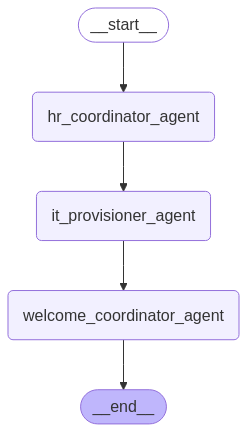

# Workflow Execution

This final section demonstrates how to run the compiled workflow and inspect its results.

- Prepare Input: Sample data for a new hire is created in a dictionary format, matching the `new_hire_details` field expected by the `OnboardingWorkflowState`.
- Invoke Workflow: The invoke method of the compiled workflow is called with the initial input. This starts the execution of the graph, beginning with the START node and proceeding through the defined edges.
- Inspect Output: After the workflow completes (reaches the END node), the response variable will contain the final state of the `OnboardingWorkflowState`.

In [28]:
new_hire = {
    "name": "Alice Wonderland",
    "email": "alice.w@example.com",
    "job_title": "Senior Software Engineer",
    "start_date": (datetime.date.today() + datetime.timedelta(days=14)).strftime("%Y-%m-%d"),
    "shipping_address": "123 Main St, Anytown, USA 12345"
}

In [29]:
response = onboarding_workflow.invoke(input={'new_hire_details': new_hire})

--- Running HR Coordinator Node ---
--- HR Tool: Creating record for Alice Wonderland (alice.w@example.com), Title: Senior Software Engineer, Start: 2025-12-26 ---
--- HR Tool: Initiating background check for Alice Wonderland (ID: EMP64457, Email: alice.w@example.com) ---
HR Agent Raw Output Text: ```json
{
  "employee_id": "EMP64457",
  "hr_record_status": "Employee record created successfully for Alice Wonderland with ID EMP64457.",
  "background_check_status": "Background check initiated for EMP64457. Tracking ID: BGC-241276."
}
```
--- Parsing HR Agent output for structured data ---
Structured HR Result: employee_id='EMP64457' hr_record_status='Employee record created successfully for Alice Wonderland with ID EMP64457.' background_check_status='Background check initiated for EMP64457. Tracking ID: BGC-241276.'
--- Running IT Provisioner Node ---
--- IT Tool: Assigning hardware for EMP64457, Title: Senior Software Engineer, Addr: 123 Main St, Anytown... ---
--- IT Tool: Provisioning

In [30]:
print(response['final_onboarding_status'])

Completed Successfully


In [31]:
print(response['employee_id'])

EMP64457


In [32]:
print(response['welcome_email_content'])

{'subject': 'Welcome to Example Company, Alice Wonderland!', 'body': 'Dear Alice Wonderland,\n\nWe are thrilled to welcome you to Example Company as our new Senior Software Engineer! Your first day is scheduled for 2025-12-26.\n\nPlease plan to arrive by 9:00 AM. Your primary contact for the first day will be Hiring Manager.\n\nYour IT accounts have been set up. Your username is: awonderland. You will receive separate instructions on setting your initial password.\n\nWe have also scheduled some introductory training sessions for you (details below or in a separate calendar invite).\n\nWe look forward to having you on the team!\n\nBest regards,\nExample Company HR'}


In [33]:
print(response['it_account_status'])

Standard accounts provisioned for EMP64457 with username 'awonderland'.
